<a href="https://colab.research.google.com/github/Sanketr113/B.Tech-Project---Optimizing-Voice-Activity-Detection-with-Vision-Transformer-or-ViT/blob/main/BTP_VAD_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone git@github.com/PratikAgrawal02/VAD.git

Cloning into 'BTP_VAD'...
remote: Enumerating objects: 90503, done.
remote: Counting objects: 100% (6048/6048), done.
remote: Compressing objects: 100% (6039/6039), done.
remote: Total 90503 (delta 11), reused 6040 (delta 8), pack-reused 84455
Receiving objects: 100% (90503/90503), 1.13 GiB | 23.10 MiB/s, done.
Resolving deltas: 100% (19757/19757), done.
Updating files: 100% (88309/88309), done.


In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os
import cv2

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
base_dir = '/content/BTP_VAD/BTP!/data'
dataset = []
labels = []

#ignore the .DS_Store file
for folder in os.listdir(base_dir):
    if folder == '.DS_Store':
        continue
    for file in os.listdir(os.path.join(base_dir, folder)):
        if file == '.DS_Store':
            continue
        image = cv2.imread(os.path.join(base_dir, folder, file))
        image = cv2.resize(image , (32 , 32))

        if image is None:
            print(os.path.join(base_dir, folder, file))
            continue
        dataset.append(image)
        # if(len(dataset)==2549):
        #     print(os.path.join(base_dir, folder, file))
        #     continue
        if folder == 'Class0':
            labels.append(0)
        elif folder =='Class1':
            labels.append(1)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(np.array(dataset))

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=(32,32,3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(1 , activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    np.array(dataset), np.array(labels), test_size=0.2, random_state=42)

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    loss, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {round(loss * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history , model


In [ ]:
vit_classifier = create_vit_classifier()
history , model = run_experiment(vit_classifier)

Epoch 1/100
21/21 [==============================] - 23s 607ms/step - loss: 1.3572 - accuracy: 0.7206 - val_loss: 0.3642 - val_accuracy: 0.7956
Epoch 2/100
21/21 [==============================] - 9s 410ms/step - loss: 0.4379 - accuracy: 0.7605 - val_loss: 0.3406 - val_accuracy: 0.8409
Epoch 3/100
21/21 [==============================] - 9s 412ms/step - loss: 0.3952 - accuracy: 0.7837 - val_loss: 0.3310 - val_accuracy: 0.8660
Epoch 4/100
21/21 [==============================] - 9s 419ms/step - loss: 0.3585 - accuracy: 0.8100 - val_loss: 0.3049 - val_accuracy: 0.8693
Epoch 5/100
21/21 [==============================] - 8s 362ms/step - loss: 0.3426 - accuracy: 0.8258 - val_loss: 0.3006 - val_accuracy: 0.8442
Epoch 6/100
21/21 [==============================] - 9s 415ms/step - loss: 0.3326 - accuracy: 0.8269 - val_loss: 0.2854 - val_accuracy: 0.8878
Epoch 7/100
21/21 [==============================] - 8s 362ms/step - loss: 0.3261 - accuracy: 0.8381 - val_loss: 0.2899 - val_accuracy: 0.887

<ipython-input-48-655a23125f7c>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'bo', label='Training acc', color='r')
<ipython-input-48-655a23125f7c>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss' , color='r')


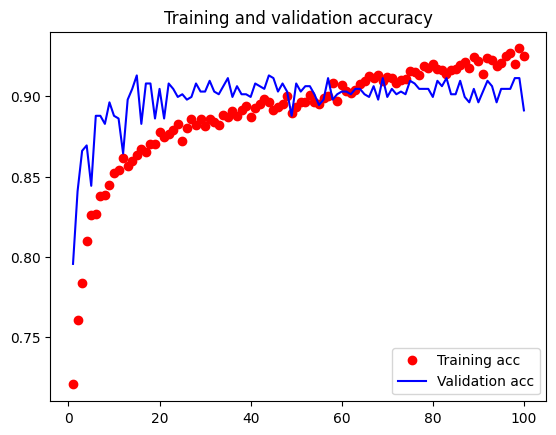

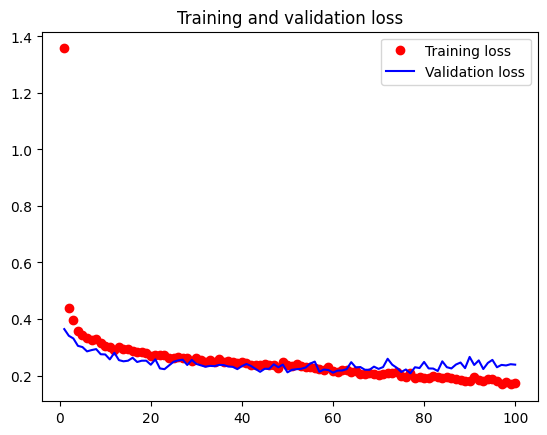

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']



import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc', color='r')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss' , color='r')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
preds = model.predict(X_test[:4])

1/1 [==============================] - 1s 1s/step


In [ ]:
preds[3]

array([0.36402616], dtype=float32)

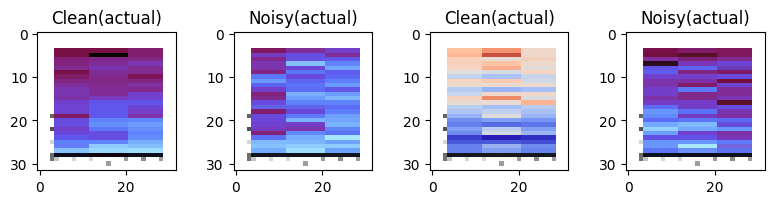

In [ ]:
fig, axs = plt.subplots(1,4 , figsize=(8,8))
fig.tight_layout()
for i in range(4):
  axs[i].imshow(X_test[i])
  if y_test[i]==1:
    axs[i].set_title('Clean(actual)')
  if y_test[i]==0:
    axs[i].set_title('Noisy(actual)')


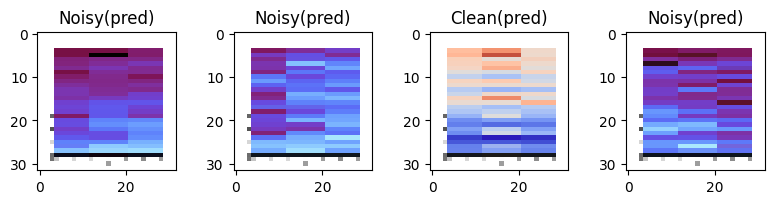

In [ ]:
fig, axs = plt.subplots(1,4 , figsize=(8,8))
fig.tight_layout()
for i in range(4):
  axs[i].imshow(X_test[i])
  if preds[i]>=0.5:
    axs[i].set_title('Clean(pred)')
  if preds[i]<0.5:
    axs[i].set_title('Noisy(pred)')
